In [3]:
# Update environment (if needed)
# !sudo apt update

# Download and install Java
!sudo apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install Apache Spark 3.3.0 with Hadoop 3
!wget -nc -q https://downloads.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz

# Unzip the folder
!tar xf  spark-3.3.1-bin-hadoop3.tgz

# Install findspark library that will locate Spark on the system
!pip install -q findspark
!pip install pyspark

# Setting the environment variables, to enable running PySpark in Colab environment.
import os
import shutil
from itertools import islice
import requests

import pandas as pd
import matplotlib.pyplot as plt

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
# from pyspark.sql import functions as F
from pyspark.sql.types import *

# Create spark_session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

spark.version

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 39 kB/s 
     |████████████████████████████████| 199 kB 46.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=5082be92f4c4a471145ba066718aeda23ca3bce97d0df45011762703610aadc4
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


'3.3.1'

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Check the content of BDP folder in GDrive
!mkdir "/content/drive/My Drive/Colab Datasets/BDP/Assignment6/"
!ls "/content/drive/My Drive/Colab Datasets/BDP/Assignment6/"

mkdir: cannot create directory ‘/content/drive/My Drive/Colab Datasets/BDP/Assignment6/’: File exists
2007.csv  2008.csv


In [6]:
url = 'https://storage.googleapis.com/msca-bdp-data-open/airlines/2007.csv'
r = requests.get(url)
open('/content/drive/My Drive/Colab Datasets/BDP/Assignment6/2007.csv' , 'wb').write(r.content)
print('Downloaded File')

Downloaded File


In [7]:
url = 'https://storage.googleapis.com/msca-bdp-data-open/airlines/2008.csv'
r = requests.get(url)
open('/content/drive/My Drive/Colab Datasets/BDP/Assignment6/2008.csv' , 'wb').write(r.content)
print('Downloaded File')

Downloaded File


In [8]:
!ls -l "/content/drive/My Drive/Colab Datasets/BDP/Assignment6/"

total 1359660
-rw------- 1 root root 702878193 Nov  4 03:19 2007.csv
-rw------- 1 root root 689413344 Nov  4 03:19 2008.csv


In [9]:
%%time
path = "/content/drive/My Drive/Colab Datasets/BDP/Assignment6/"
def read_file(file_name):
  csv_file = spark.read.csv(path + file_name, header='true', inferSchema='true', sep=',', quote='"').\
        select(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'DepDelay', 'ArrDelay', 'Origin', 'Dest', 'Cancelled'])
  return csv_file

df_2007 = read_file('2007.csv')
df_2008 = read_file('2008.csv')

df_2007.orderBy('DepDelay', ascending=False).show(10)

+----+-----+----------+---------+-------+----------+-------+----------+--------+--------+------+----+---------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|DepDelay|ArrDelay|Origin|Dest|Cancelled|
+----+-----+----------+---------+-------+----------+-------+----------+--------+--------+------+----+---------+
|2007|    1|         2|        2|     NA|       730|     NA|       830|      NA|      NA|   DAL| HOU|        1|
|2007|    1|         2|        2|     NA|      1820|     NA|      1940|      NA|      NA|   OAK| SNA|        1|
|2007|    1|         2|        2|     NA|       930|     NA|      1030|      NA|      NA|   DAL| HOU|        1|
|2007|    1|         2|        2|     NA|      2025|     NA|      2115|      NA|      NA|   AUS| DAL|        1|
|2007|    1|         2|        2|     NA|      1230|     NA|      1330|      NA|      NA|   DAL| HOU|        1|
|2007|    1|         2|        2|     NA|      1600|     NA|      1700|      NA|      NA|   HOU| DAL|   

In [41]:
#Since Data has NA values, need to filter NA out
def clean_csv(df):
  return df.filter((df.Cancelled != 1)).\
              withColumn("DepDelay", df["DepDelay"].cast(IntegerType())).\
              withColumn("ArrDelay", df["ArrDelay"].cast(IntegerType())).\
              filter((df.ArrDelay > 0)).filter((df.DepDelay > 0))

df_2007 = clean_csv(df_2007)
df_2008 = clean_csv(df_2008)

In [32]:
df_2007.orderBy('DepDelay').show(10)

+----+-----+----------+---------+-------+----------+-------+----------+--------+--------+------+----+---------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|DepDelay|ArrDelay|Origin|Dest|Cancelled|
+----+-----+----------+---------+-------+----------+-------+----------+--------+--------+------+----+---------+
|2007|    1|         2|        2|   1241|      1240|   1416|      1415|       1|       1|   BWI| DTW|        0|
|2007|    1|         2|        2|   1111|      1110|   1515|      1510|       1|       5|   LAS| MAF|        0|
|2007|    1|         2|        2|    811|       810|    902|       900|       1|       2|   DAL| AUS|        0|
|2007|    1|         1|        1|   1046|      1045|   1150|      1140|       1|      10|   TPA| FLL|        0|
|2007|    1|         2|        2|   2101|      2100|   2157|      2155|       1|       2|   DAL| HOU|        0|
|2007|    1|         2|        2|   1151|      1150|   1243|      1240|       1|       3|   AUS| DAL|   

In [31]:
df_2007.orderBy('DepDelay', ascending=False).show(10)

+----+-----+----------+---------+-------+----------+-------+----------+--------+--------+------+----+---------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|DepDelay|ArrDelay|Origin|Dest|Cancelled|
+----+-----+----------+---------+-------+----------+-------+----------+--------+--------+------+----+---------+
|2007|   10|         3|        3|    820|      1259|   1109|      1551|    2601|    2598|   PBI| DTW|        0|
|2007|   12|         1|        6|   1536|       700|   1627|       805|    1956|    1942|   ALO| MSP|        0|
|2007|   10|         2|        2|   2351|      1720|   1244|       556|    1831|    1848|   HNL| MSP|        0|
|2007|   10|        28|        7|   1256|       800|   1340|       905|    1736|    1715|   FWA| DTW|        0|
|2007|    9|         1|        6|   1309|       900|   2110|      1725|    1689|    1665|   FAI| MSP|        0|
|2007|    9|        28|        5|   1035|       638|   1124|       749|    1677|    1655|   PIT| DTW|   

## Q1 Which locations (Origin and Dest pairs) had the worst delays for both arrivals (ArrDelay) and departures (DepDelay) - for each year


### 2007 Arrival delay and Departure delay

In [33]:
def pairs(df, type_of_delay):
  df.groupby(['Origin','Dest']).avg(type_of_delay)\
        .withColumnRenamed('avg('+type_of_delay+')', 'Average ' + type_of_delay)\
        .orderBy(['Average ' + type_of_delay], ascending=False).show(1)

In [34]:
print("Worst Departure Delay Pairs 2007")
pairs(df_2007, 'DepDelay')
print("Worst Arrival Delay Pairs 2007")
pairs(df_2007, 'ArrDelay')

Worst Departure Delay Pairs 2007
+------+----+----------------+
|Origin|Dest|Average DepDelay|
+------+----+----------------+
|   ONT| IAD|           386.0|
+------+----+----------------+
only showing top 1 row

Worst Arrival Delay Pairs 2007
+------+----+----------------+
|Origin|Dest|Average ArrDelay|
+------+----+----------------+
|   ONT| IAD|           370.0|
+------+----+----------------+
only showing top 1 row



### 2008 Arrival delay and Departure delay

In [36]:
print("Worst Departure Delay Pairs 2008")
pairs(df_2008, 'DepDelay')
print("Worst Arrival Delay Pairs 2008")
pairs(df_2008, 'ArrDelay')

Worst Departure Delay Pairs 2008
+------+----+----------------+
|Origin|Dest|Average DepDelay|
+------+----+----------------+
|   CMI| SPI|           587.0|
+------+----+----------------+
only showing top 1 row

Worst Arrival Delay Pairs 2008
+------+----+----------------+
|Origin|Dest|Average ArrDelay|
+------+----+----------------+
|   CMI| SPI|           575.0|
+------+----+----------------+
only showing top 1 row



## Q2. Which locations had fewest delays.

In [37]:
def pairs_fewest_delay(df):
  df\
      .groupby(['Origin']).agg(count('DepDelay'))\
      .withColumnRenamed('count(DepDelay)', 'Count of Departure Delay')\
      .orderBy(['Count of Departure Delay']).show(5)

In [38]:
print("Fewest Departure Delay 2007")
pairs_fewest_delay(df_2007)
print("Fewest Departure Delay 2008")
pairs_fewest_delay(df_2008)

Fewest Departure Delay 2007
+------+------------------------+
|Origin|Count of Departure Delay|
+------+------------------------+
|   MKC|                       1|
|   ISO|                       1|
|   PIR|                       3|
|   EAU|                      10|
|   ADK|                      26|
+------+------------------------+
only showing top 5 rows

Fewest Departure Delay 2008
+------+------------------------+
|Origin|Count of Departure Delay|
+------+------------------------+
|   INL|                       1|
|   TUP|                       1|
|   PUB|                       2|
|   PIR|                       2|
|   BJI|                       4|
+------+------------------------+
only showing top 5 rows



## Q3. Do you see any significant seasonality effects for delays?

In [65]:
def seasonal_delay(df):
  delay_df = df.select([concat(col("Year"),lit('-'),col("Month")),'DepDelay'])
  delay_df_grouped = delay_df.withColumnRenamed('concat(Year, -, Month)', 'Date').\
                      groupby('Date').agg(avg('DepDelay')).\
                      withColumnRenamed('avg(DepDelay)', 'Departure Delay over time (Monthly)')
  df_pandas_delay = delay_df_grouped.toPandas()
  df_pandas_delay['Date'] = pd.to_datetime(df_pandas_delay['Date'])
  return df_pandas_delay.set_index('Date')

In [66]:
df_2007_monthly_delays = seasonal_delay(df_2007)
df_2008_monthly_delays = seasonal_delay(df_2008)

,Departure Delay over time (Monthly)
Date,
2007-01-01,36.807279
2007-02-01,40.012656
2007-03-01,39.168691
2007-04-01,37.575635
2007-05-01,34.895944


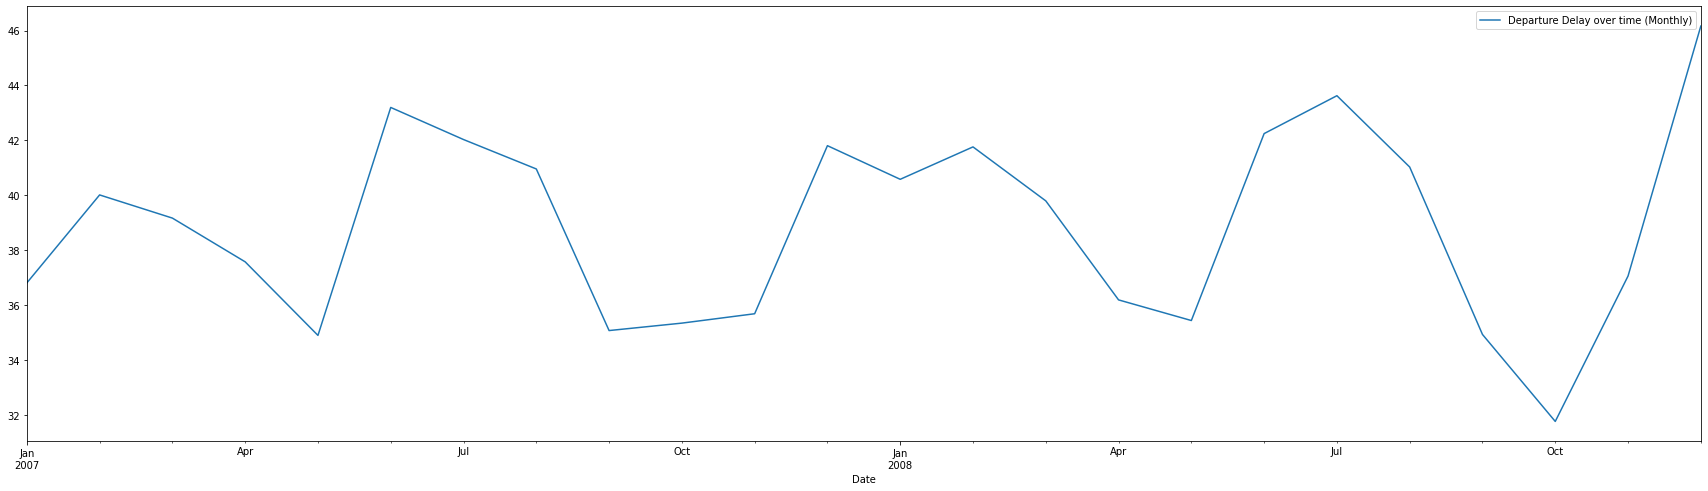

In [67]:
df_monthly_delays = pd.concat([df_2007_monthly_delays, df_2008_monthly_delays]).sort_index()
display(df_monthly_delays.head(5))
df_monthly_delays.plot(figsize = (30, 8))

## Q4. Do you see any increase or decrease in delays on weekends?


In [68]:
def daily_delay(df, year):
  delay_df = df.select(['DayofWeek','DepDelay'])
  delay_df_groupby = delay_df.groupby('DayofWeek').agg(count('DepDelay')).withColumnRenamed('count(DepDelay)', 'Number of flights getting delayed in ' + year)
  df_pandas_delay = delay_df_groupby.toPandas()
  df_pandas_delay = df_pandas_delay.set_index('DayofWeek')
  return df_pandas_delay.sort_index()

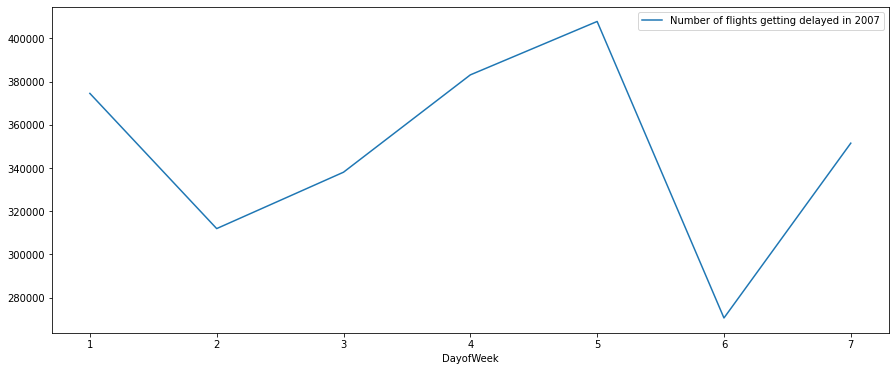

In [69]:
daily_delay(df_2007, '2007').plot(figsize = (15, 6))

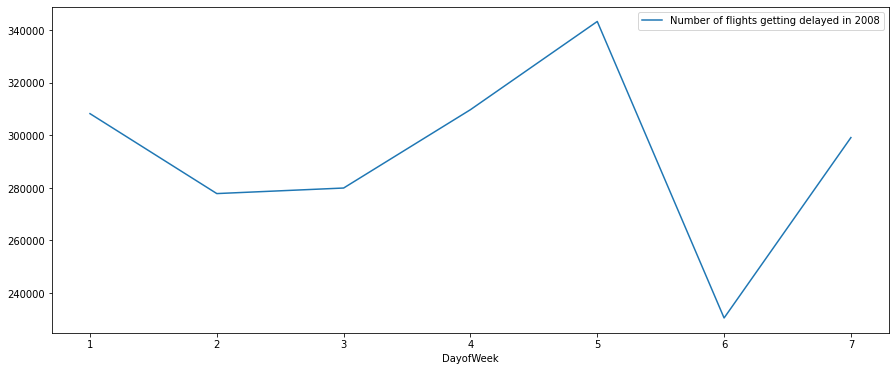

In [70]:
daily_delay(df_2008, '2008').plot(figsize = (15, 6))

## Q5. Are flights equally distributed throughout the day?
* ### Plot the distribution of DepTime, ArrTime (actual departure and arrival time)

In [79]:
def pad_times_hourly(df):
  df_time = df.withColumn("ArrTime", lpad(df.ArrTime, 4, '0')).\
                  withColumn("DepTime", lpad(df.DepTime, 4, '0'))
  return df_time

def mapping_flight_timings(df, year):
  df_time = pad_times_hourly(df)
  arr_timing_df = df_time.select(['ArrTime'])
  arr_timing_df_groupby = arr_timing_df.groupby(['ArrTime']).\
                  agg(count('ArrTime')).\
                  withColumnRenamed('count(ArrTime)', 'Number of flights arriving each hour ' + year)
  arr_df_pandas_timing = arr_timing_df_groupby.toPandas().set_index('ArrTime').sort_index()

  dep_timing_df = df_time.select(['DepTime'])
  dep_timing_df_groupby = dep_timing_df.groupby(['DepTime']).\
                  agg(count('DepTime')).\
                  withColumnRenamed('count(DepTime)', 'Number of flights departing each hour ' + year)
  dep_df_pandas_timing = dep_timing_df_groupby.toPandas().set_index('DepTime').sort_index()
  return arr_df_pandas_timing, dep_df_pandas_timing

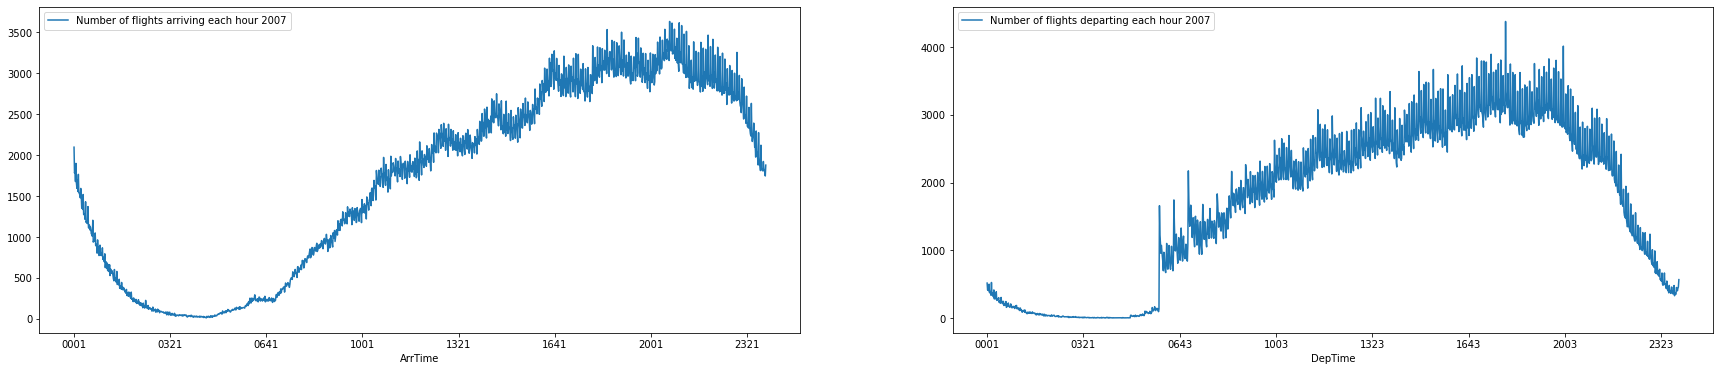

In [80]:
df_arr, df_dep = mapping_flight_timings(df_2007, '2007')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30, 6))
df_arr.plot(ax=axes[0])
df_dep.plot(ax=axes[1])

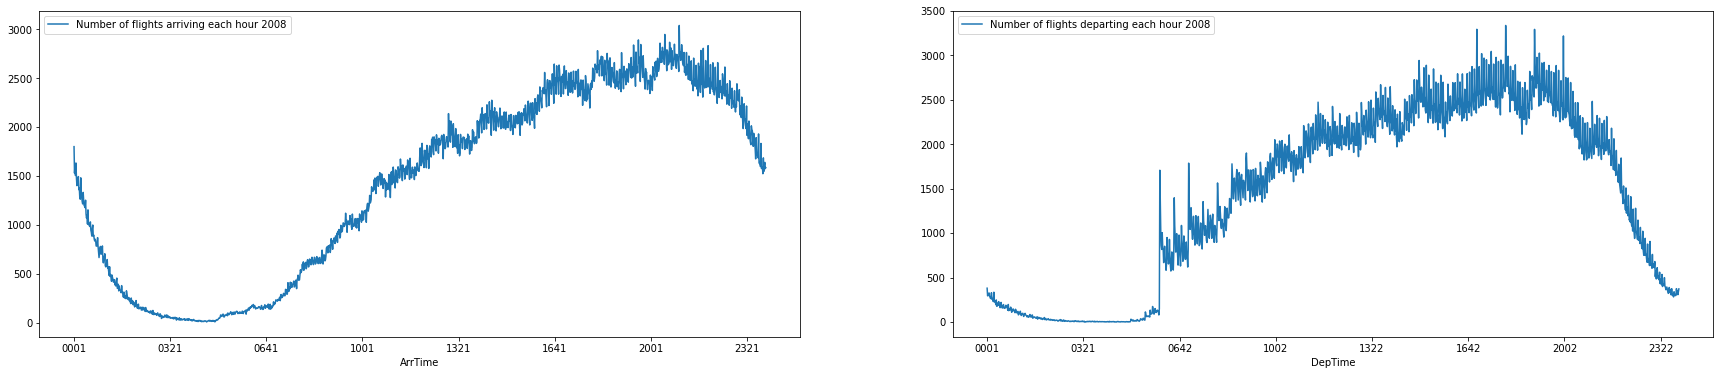

In [81]:
df_arr, df_dep = mapping_flight_timings(df_2008, '2008')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30, 6))
df_arr.plot(ax=axes[0])
df_dep.plot(ax=axes[1])

## Q6. Do you see the worst delays at any certain times of the day?
* #### Compare DepTime, ArrTime with CRSDepTime, CRSArrTime (scheduled arrival and departure time; CRS is the Computer Reservation System)

In [76]:
def delay_during_day(df, year):
  df = df.withColumn('Difference_DepTime', (df['DepDelay'])).\
          withColumn('Difference_ArrTime', ( df['ArrDelay'] ))
  df_analyze_delays_hourly = pad_times_hourly(df.select(['Difference_DepTime', 'Difference_ArrTime', 'DepTime', 'ArrTime']))

  df_analyze_delays_hourly_arr = df_analyze_delays_hourly.select(['ArrTime', 'Difference_ArrTime'])
  delay_df_groupby_arr = df_analyze_delays_hourly_arr.groupby(['ArrTime']).\
                agg(avg('Difference_ArrTime')).\
                withColumnRenamed('avg(Difference_ArrTime)', 'Average Flight Arrival Delay (Hourly) ' + year)
  df_pandas_delay_arr = delay_df_groupby_arr.toPandas().set_index('ArrTime').sort_index()

  df_analyze_delays_hourly_dep = df_analyze_delays_hourly.select(['DepTime', 'Difference_DepTime'])
  delay_df_groupby_dep = df_analyze_delays_hourly_dep.groupby(['DepTime']).\
                agg(avg('Difference_DepTime')).\
                withColumnRenamed('avg(Difference_DepTime)', 'Average Flight Departure Delay (Hourly) ' + year)
  df_pandas_delay_dep = delay_df_groupby_dep.toPandas().set_index('DepTime').sort_index()

  return df_pandas_delay_arr, df_pandas_delay_dep

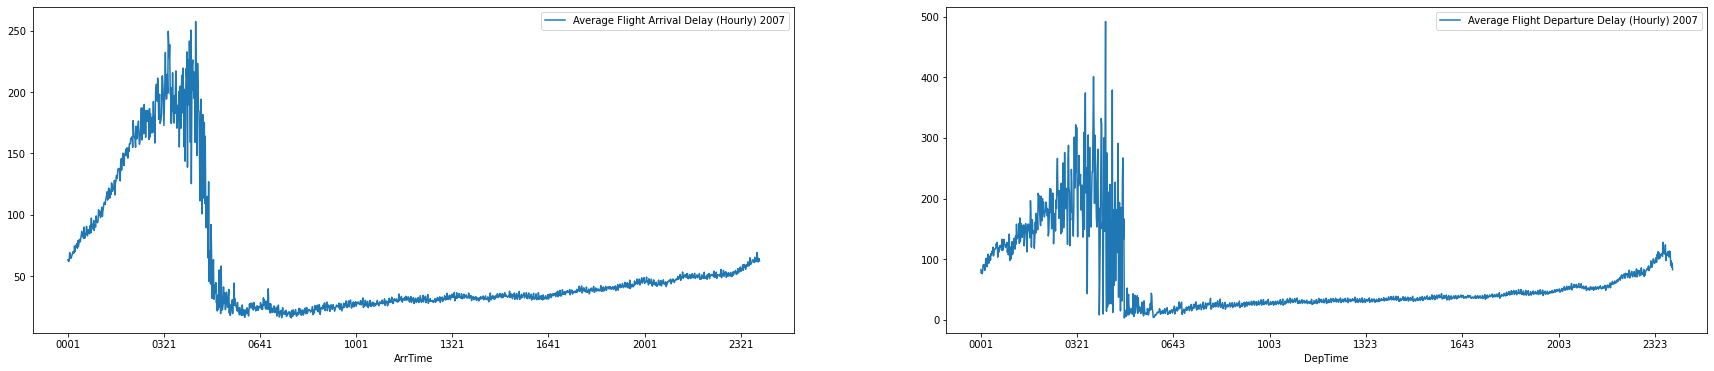

In [77]:
df_arr, df_dep = delay_during_day(df_2007, '2007')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30, 6))
df_arr.plot(ax=axes[0])
df_dep.plot(ax=axes[1])

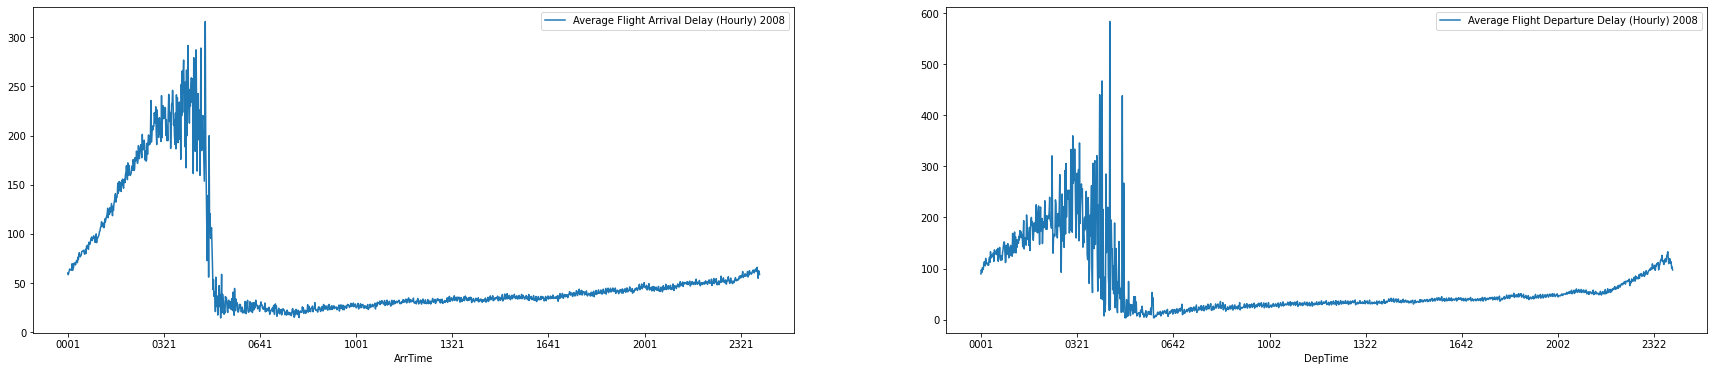

In [78]:
df_arr, df_dep = delay_during_day(df_2008, '2008')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30, 6))
df_arr.plot(ax=axes[0])
df_dep.plot(ax=axes[1])